In [103]:
import sddk
import pandas as pd
import requests
pd.options.display.max_columns = 1000 # to see all columns
import json
import re
import geopandas as gpd
import warnings
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj
warnings.filterwarnings('ignore')
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import geoplot as gplt
import networkx as nx
import numbers
from interval import interval

In [104]:
plt.rcParams['figure.dpi'] = 300

In [105]:
# read LIRE dataset from zenodo
# !!! use carefully - takes time 
LIRE = gpd.read_file("https://zenodo.org/record/5074774/files/LIREg.geojson?download=1", driver="geoJSON")
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,"['Augusti/Augustae', 'ordo equester', 'tria no...",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313,Augusti/Augustae; litterae erasae; ordo equest...,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,HD052964,None,Fortissimo et Piissimo Caesari domino nostro G...,Cowey,honorific inscription,3-5.3 cm,"AE 1993, 1406.; V. Papadopoulou, AD 43 B, 1988...",checked with photo,99 cm,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,"[{'name': 'Gal. Val. [[Maximiano]]', 'nomen': ...",67 cm,None,statue base,Epirus,67 cm,Fortissimo et piis/simo Caesari d(omino) n(ost...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Photike,2014-09-16,Ípeiros,Paramythía,https://edh-www.adw.uni-heidelberg.de/edh/geog...,None,https://www.trismegistos.org/text/121715,{ },{ },121715,"['http://www.trismegistos.org/place/000655', '...",Fortissimo et piissimo Caesari...,309 AD – 313 AD,21,unbestimmt,57.0,Statuenbasis,138,unbestimmt,1000.0,69,Ehreninschrift,honorific inscription,Certain,99.0,67.0,67.0,NULL,statue base,Certain,Epirus,Certain,Greece,Certain,Photike,Certain,Ípeiros,Certain,Paramythía,Certain,Agios Athanasios,Certain,309 AD – 313 AD,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Agios Athanasios,None,Fragma Kalama,None,data available,None,None,313.0,Latin,309.0,"[20.7668, 39.4512]",Fortissimo et piissimo Caesari domino nostro G...,rest,False,Dodona,31,1000.0,"[20.787767, 39.546432]",minor,0.097513,honorific inscription,1.0,POINT (20.76680 39.45120)
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,"['Augusti/Augustae', 'viri']",{ },,,to 276; b: 276 to 282 \n\n \n \nImp...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,276,Augusti/Augustae; miliaria; viri,37.454501,22.4208

In [106]:
orbis_hanson_gpd = gpd.read_parquet("../data/orbis_hanson_gpd.par")
orbis_hanson_gpd.head(5)

,id,label,x,y,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist
521,50474,Portus Magnus,35.808,-0.266,POINT (-0.26600 35.80800),Portus Magnus,1182,1000.0,"[-0.266018, 35.807917]",0.000085
458,50418,Vienna,45.524,4.878,POINT (4.87800 45.52400),Vienna,658,15332.0,"[4.878056, 45.524167]",0.000176
210,50131,Corduba,37.884,-4.780,POINT (-4.78000 37.88400),Corduba,336,19404.0,"[-4.78025, 37.88376]",0.000347
319,50172,Faventia,44.285,11.883,POINT (11.88300 44.28500),Faventia,1014,5399.0,"[11.882989, 44.285348]",0.000348
109,50125,Ulpia Traiana Tricensimae,51.668,6.445,POINT (6.44500 51.66800),Colonia Ulpia Traiana,661,14596.0,"[6.444591, 51.668014]",0.000409


# Map inscriptions on orbis sites

In [107]:
def ckdnearest(inscriptions, sites_gdf):
    sites_gdf = sites_gdf[["id", "geometry"]] 
    sites_gdf.rename(columns={"id" : "orbis_id"}, inplace=True)
    nA = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(sites_gdf.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = sites_gdf.iloc[idx].rename(columns={"geometry": "city_geometry"}).reset_index(drop=True)
    gdB_nearest["city_geometry"] = [[geom.x, geom.y] for geom in gdB_nearest["city_geometry"]]
    gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='orbis_site_dist')
        ], 
        axis=1)
    return gdf

#ckdnearest(gpd1, gpd2)

In [108]:
%%time
LIRE = ckdnearest(LIRE, orbis_hanson_gpd)
LIRE.head(5)

CPU times: user 5.48 s, sys: 185 ms, total: 5.66 s
Wall time: 5.66 s


,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry,orbis_id,city_geometry,orbis_site_dist
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,"['Augusti/Augustae', 'ordo equester', 'tria no...",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313,Augusti/Augustae; litterae erasae; ordo equest...,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,HD052964,None,Fortissimo et Piissimo Caesari domino nostro G...,Cowey,honorific inscription,3-5.3 cm,"AE 1993, 1406.; V. Papadopoulou, AD 43 B, 1988...",checked with photo,99 cm,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,"[{'name': 'Gal. Val. [[Maximiano]]', 'nomen': ...",67 cm,None,statue base,Epirus,67 cm,Fortissimo et piis/simo Caesari d(omino) n(ost...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Photike,2014-09-16,Ípeiros,Paramythía,https://edh-www.adw.uni-heidelberg.de/edh/geog...,None,https://www.trismegistos.org/text/121715,{ },{ },121715,"['http://www.trismegistos.org/place/000655', '...",Fortissimo et piissimo Caesari...,309 AD – 313 AD,21,unbestimmt,57.0,Statuenbasis,138,unbestimmt,1000.0,69,Ehreninschrift,honorific inscription,Certain,99.0,67.0,67.0,NULL,statue base,Certain,Epirus,Certain,Greece,Certain,Photike,Certain,Ípeiros,Certain,Paramythía,Certain,Agios Athanasios,Certain,309 AD – 313 AD,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Agios Athanasios,None,Fragma Kalama,None,data available,None,None,313.0,Latin,309.0,"[20.7668, 39.4512]",Fortissimo et piissimo Caesari domino nostro G...,rest,False,Dodona,31,1000.0,"[20.787767, 39.546432]",minor,0.097513,honorific inscription,1.0,POINT (20.76680 39.45120),50273,"[20.735, 39.007]",0.445337
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,"['Augusti/Augustae', 'viri']",{ },,,to 276; b: 276 to 282 \n\n \n \nImp...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,http://db.edcs.eu/epigr/partner.php

In [109]:
# testing overlap between two intervals
# len 0 = no overlap
# len 1 = overlap
not_before, not_after = 0, 300
period_start, period_end = 101, 200
len(interval[period_start, period_end] & interval[not_before, not_after])

1

In [110]:
def temporal_overlap(period_start, period_end, inscr_start, inscr_end):
    if np.isnan(inscr_start):
        inscr_start = inscr_end
    if np.isnan(inscr_end):
        inscr_end = inscr_start
    if len(interval[period_start, period_end] & interval[inscr_start, inscr_end]) > 0:
        return True
    else:
        return False

In [111]:
%%time
LIRE_period1 = LIRE[LIRE.apply(lambda row: temporal_overlap(1, 100, row["not_before"], row["not_after"]), axis=1)] 
LIRE_period2 = LIRE[LIRE.apply(lambda row: temporal_overlap(101, 200, row["not_before"], row["not_after"]), axis=1)] 
LIRE_period3 = LIRE[LIRE.apply(lambda row: temporal_overlap(201, 300, row["not_before"], row["not_after"]), axis=1)] 

CPU times: user 26.4 s, sys: 204 ms, total: 26.6 s
Wall time: 26.6 s


In [113]:
LIRE_period0 = LIRE[LIRE.apply(lambda row: temporal_overlap(-2000, 1, row["not_before"], row["not_after"]), axis=1)] 
LIRE_period4 = LIRE[LIRE.apply(lambda row: temporal_overlap(301, 2000, row["not_before"], row["not_after"]), axis=1)] 

In [114]:
for per in [LIRE_period0, LIRE_period1, LIRE_period2, LIRE_period3, LIRE_period4]:
    print(len(per))

37355
56000
67838
43973
19856


In [115]:
def get_inscr_ids(orbis_id, source, LIRE_period):
    LIRE_subset = LIRE_period[LIRE_period["orbis_id"]==orbis_id]
    if source == "EDCS":
        ids = LIRE_subset[LIRE_subset["EDCS-ID"].notnull() & LIRE_subset["EDH-ID"].isnull()]["EDCS-ID"].tolist()
    else:
        ids = LIRE_subset[LIRE_subset["EDH-ID"].notnull()]["EDH-ID"].tolist()
    return ids

In [116]:
get_inscr_ids(50474, "EDH", LIRE_period3)

['HD033385',
 'HD000463',
 'HD052542',
 'HD033325',
 'HD033415',
 'HD033388',
 'HD030633']

In [117]:
orbis_hanson_gpd.head(5)

,id,label,x,y,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist
521,50474,Portus Magnus,35.808,-0.266,POINT (-0.26600 35.80800),Portus Magnus,1182,1000.0,"[-0.266018, 35.807917]",0.000085
458,50418,Vienna,45.524,4.878,POINT (4.87800 45.52400),Vienna,658,15332.0,"[4.878056, 45.524167]",0.000176
210,50131,Corduba,37.884,-4.780,POINT (-4.78000 37.88400),Corduba,336,19404.0,"[-4.78025, 37.88376]",0.000347
319,50172,Faventia,44.285,11.883,POINT (11.88300 44.28500),Faventia,1014,5399.0,"[11.882989, 44.285348]",0.000348
109,50125,Ulpia Traiana Tricensimae,51.668,6.445,POINT (6.44500 51.66800),Colonia Ulpia Traiana,661,14596.0,"[6.444591, 51.668014]",0.000409


In [118]:
orbis_hanson_gpd["EDH_all"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE))
orbis_hanson_gpd["EDCS_all"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE))

In [119]:
orbis_hanson_gpd["LIRE_total_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_all"])+len(row["EDCS_all"]), axis=1)

In [120]:
orbis_hanson_gpd.sort_values("pop_est", ascending=False).head(5)

,id,label,x,y,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist,EDH_all,EDCS_all,LIRE_total_N
2,50327,Roma,41.891,12.485,POINT (12.48500 41.89100),Roma,992,923313.0,"[12.485098, 41.892777]",0.001780,"[HD016234, HD007300, HD006780, HD016689, HD002...","[EDCS-22700240, EDCS-22700241, EDCS-22700242, ...",38647
164,50017,Alexandria,31.200,29.910,POINT (29.91000 31.20000),Alexandria (Aegyptus),110,410502.0,"[29.903728000000005, 31.195024]",0.008006,"[HD025477, HD017883, HD032199, HD045448, HD019...","[EDCS-71300297, EDCS-58200213, EDCS-20800415, ...",37
359,50230,Lepcis Magna,32.637,14.292,POINT (14.29200 32.63700),Lepcis Magna,180,153722.0,"[14.29306, 32.63833]",0.001701,"[HD021906, HD045234, HD045235, HD018125, HD021...","[EDCS-51500074, EDCS-51500075, EDCS-51500076, ...",319
433,50613,Rhodos,36.440,28.230,POINT (28.23000 36.44000),Rhodus,309,130398.0,"[28.227007, 36.443235]",0.004407,[],[EDCS-70200274],1
302,50024,Antiochia,36.208,36.169,POINT (36.16900 36.20800),Antiochia (Syria),1324,124930.0,"[36.169629, 36.210172]",0.002261,[HD061603],[],1


In [121]:
%%time
orbis_hanson_gpd["EDH_per1"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period1))
orbis_hanson_gpd["EDCS_per1"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period1))

orbis_hanson_gpd["EDH_per2"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period2))
orbis_hanson_gpd["EDCS_per2"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period2))

orbis_hanson_gpd["EDH_per3"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period3))
orbis_hanson_gpd["EDCS_per3"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period3))

CPU times: user 33.4 s, sys: 6.64 ms, total: 33.4 s
Wall time: 33.4 s


In [122]:
orbis_hanson_gpd["EDH_per0"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period0))
orbis_hanson_gpd["EDCS_per0"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period0))

orbis_hanson_gpd["EDH_per4"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDH", LIRE_period4))
orbis_hanson_gpd["EDCS_per4"] = orbis_hanson_gpd["id"].apply(lambda x: get_inscr_ids(x, "EDCS", LIRE_period4))

In [123]:
orbis_hanson_gpd["LIRE_per0_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per0"])+len(row["EDCS_per0"]), axis=1)
orbis_hanson_gpd["LIRE_per1_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per1"])+len(row["EDCS_per1"]), axis=1)
orbis_hanson_gpd["LIRE_per2_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per2"])+len(row["EDCS_per2"]), axis=1)
orbis_hanson_gpd["LIRE_per3_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per3"])+len(row["EDCS_per3"]), axis=1)
orbis_hanson_gpd["LIRE_per4_N"] = orbis_hanson_gpd.apply(lambda row: len(row["EDH_per4"])+len(row["EDCS_per4"]), axis=1)

In [124]:
orbis_hanson_gpd.head(5)

,id,label,x,y,geometry,hanson_label,hanson_ID,pop_est,hanson_geo,dist,EDH_all,EDCS_all,LIRE_total_N,EDH_per1,EDCS_per1,EDH_per2,EDCS_per2,EDH_per3,EDCS_per3,EDH_per0,EDCS_per0,EDH_per4,EDCS_per4,LIRE_per0_N,LIRE_per1_N,LIRE_per2_N,LIRE_per3_N,LIRE_per4_N
521,50474,Portus Magnus,35.808,-0.266,POINT (-0.26600 35.80800),Portus Magnus,1182,1000.0,"[-0.266018, 35.807917]",0.000085,"[HD047307, HD033385, HD000463, HD052542, HD033...","[EDCS-75300340, EDCS-25500569, EDCS-25500582, ...",16,[],[EDCS-25500582],[],[EDCS-25500569],"[HD033385, HD000463, HD052542, HD033325, HD033...","[EDCS-25500560, EDCS-26800812, EDCS-26800790]",[],[EDCS-25500582],"[HD047307, HD052542, HD002861]","[EDCS-75300340, EDCS-26800834]",1,1,1,10,5
458,50418,Vienna,45.524,4.878,POINT (4.87800 45.52400),Vienna,658,15332.0,"[4.878056, 45.524167]",0.000176,"[HD052078, HD052079, HD001171, HD001626, HD001...","[EDCS-09200591, EDCS-09200592, EDCS-09500338, ...",119,"[HD001171, HD001626, HD001620, HD001623, HD049...","[EDCS-09200592, EDCS-09200607, EDCS-09200608, ...","[HD052078, HD052079, HD001617, HD052073, HD050...","[EDCS-09200591, EDCS-09200607, EDCS-09200608, ...","[HD001617, HD050227, HD053527]","[EDCS-09200591, EDCS-09500338, EDCS-09200688, ...","[HD049635, HD049631, HD044750, HD022616, HD049...","[EDCS-09200592, EDCS-09200607, EDCS-09200608, ...",[],"[EDCS-09500320, EDCS-09500263, EDCS-08501575, ...",27,53,73,30,4
210,50131,Corduba,37.884,-4.780,POINT (-4.78000 37.88400),Corduba,336,19404.0,"[-4.78025, 37.88376]",0.000347,"[HD006608, HD006605, HD006602, HD006599, HD000...","[EDCS-72600014, EDCS-72600015, EDCS-75900070, ...",1290,"[HD006599, HD000035, HD028010, HD013569, HD028...","[EDCS-72600014, EDCS-75900070, EDCS-75900071, ...","[HD006608, HD006605, HD006602, HD006599, HD000...","[EDCS-72600015, EDCS-73900025, EDCS-76900064, ...","[HD006602, HD031526, HD030365, HD030401, HD030...","[EDCS-05600095, EDCS-05600096, EDCS-21700295, ...","[HD028019, HD030356, HD010992, HD030389, HD013...","[EDCS-72600014, EDCS-75900070, EDCS-05600071, ...","[HD029485, HD010925, HD008756, HD017479, HD016...","[EDCS-35200422, EDCS-21300313, EDCS-21300316, ...",294,540,720,309,38
319,50172,Faventia,44.285,11.883,POINT (11.88300 44.28500),Faventia,1014,5399.0,"[11.882989, 44.285348]",0.000348,"[HD017246, HD016084, HD018809, HD008967, HD032...","[EDCS-64901116, EDCS-30200030, EDCS-30400520, ...",99,"[HD018809, HD032458, HD005009, HD003863, HD003...","[EDCS-04900283, EDCS-04900288, EDCS-20402028, ...","[HD017246, HD016084, HD018809, HD008967, HD010...","[EDCS-30200030, EDCS-30400520, EDCS-31200405, ...","[HD018809, HD010890]","[EDCS-64901116, EDCS-12300341, EDCS-04900290, ...","[HD018809, HD005009, HD003863, HD003860, HD004...","[EDCS-04900283, EDCS-04900288, EDCS-20402026, ...",[],"[EDCS-20402030, EDCS-23200943, EDCS-22200902, ...",35,41,51,20,5
109,50125,Ulpia Traiana Tricensimae,51.668,6.445,POINT (6.44500 51.66800),Colonia Ulpia Traiana,661,14596.0,"[6.444591, 51.668014]",0.000409,"[HD031155, HD050305, HD050306, HD050307, HD022...","[EDCS-78300132, EDCS-78300660, EDCS-72700161, ...",424,"[HD050305, HD050306, HD040731, HD040731, HD040...","[EDCS-78300132, EDCS-78300660, EDCS-72700161, ...","[HD031155, HD050305, HD050307, HD022736, HD022...","[EDCS-72700161, EDCS-72700161, EDCS-76400130, ...","[HD031155, HD040405, HD040405, HD040353, HD040...","[EDCS-17000012, EDCS-69300353, EDCS-74100142, ...","[HD067567, HD080519, HD025320, HD068220, HD018...","[EDCS-78300132, EDCS-78300660, EDCS-78300132, ...","[HD080371, HD080372, HD019137, HD016028, HD080...","[EDCS-12400333, EDCS-12400334, EDCS-61400139, ...",81,181,249,205,15


# Save for future usage

In [126]:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [127]:
def to_list(nparray):
    try: return list(nparray)
    except: return None
orbis_hanson_gpd["hanson_geo"] = orbis_hanson_gpd["hanson_geo"].apply(to_list) 

In [128]:
# save it as json (you have to drop the geometry first)
s.write_file("SDAM_data/urban/orbis_hanson_lire.json", pd.DataFrame(orbis_hanson_gpd).drop(["geometry"], axis=1))

A file with the same name ("orbis_hanson_lire.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/orbis_hanson_lire.json"


In [129]:
# save as geojson (be careful in reading back)
s.write_file("SDAM_data/urban/orbis_hanson_lire.geojson", orbis_hanson_gpd)

A file with the same name ("orbis_hanson_lire.geojson") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'geopandas.geodataframe.GeoDataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/orbis_hanson_lire.geojson"


In [130]:
# save as csv (be careful in reading back)
s.write_file("SDAM_data/urban/orbis_hanson_lire.csv", orbis_hanson_gpd)

A file with the same name ("orbis_hanson_lire.csv") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'geopandas.geodataframe.GeoDataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/urban/orbis_hanson_lire.csv"


In [131]:
# save locally as csv
orbis_hanson_gpd.to_csv("../data/orbis_hanson_lire.csv")

In [132]:
# save locally as parquet
orbis_hanson_gpd.to_parquet("../data/orbis_hanson_lire.par")

# Final Network Construction

In [133]:
orbis_hanson_gpd = gpd.read_parquet("../data/orbis_hanson_lire.par")

In [134]:
url = "https://stacks.stanford.edu/file/druid:mn425tz9757/orbis_edges_0514.csv"
orbis_edges_stanford = pd.read_csv(url)
len(orbis_edges_stanford)

2208

In [135]:
orbis_edges_stanford.head(5)

,source,target,km,days,expense,type
0,50001,50056,54.539,1.818,1.909,road
1,50001,50100,50.135,1.671,1.755,road
2,50001,50293,65.681,2.189,2.299,road
3,50001,50473,225.368,7.512,7.888,road
4,50002,50275,92.174,3.072,3.226,road


In [136]:
orbis_hanson_gpd.columns

Index(['id', 'label', 'x', 'y', 'geometry', 'hanson_label', 'hanson_ID',
       'pop_est', 'hanson_geo', 'dist', 'EDH_all', 'EDCS_all', 'LIRE_total_N',
       'EDH_per1', 'EDCS_per1', 'EDH_per2', 'EDCS_per2', 'EDH_per3',
       'EDCS_per3', 'EDH_per0', 'EDCS_per0', 'EDH_per4', 'EDCS_per4',
       'LIRE_per0_N', 'LIRE_per1_N', 'LIRE_per2_N', 'LIRE_per3_N',
       'LIRE_per4_N'],
      dtype='object')

In [137]:
orbis_edges_stanford.rename(columns={"type" : "route_type"}, inplace=True)

In [138]:
orbis_edges_stanford.head()

,source,target,km,days,expense,route_type
0,50001,50056,54.539,1.818,1.909,road
1,50001,50100,50.135,1.671,1.755,road
2,50001,50293,65.681,2.189,2.299,road
3,50001,50473,225.368,7.512,7.888,road
4,50002,50275,92.174,3.072,3.226,road


In [139]:
# node attributes for the network
nodes_keys = orbis_hanson_gpd["id"].tolist()
nodes_values_raw = orbis_hanson_gpd[["label", "x", "y", 'hanson_label', 'hanson_ID', 'pop_est', 'LIRE_total_N', 'LIRE_per0_N', 'LIRE_per1_N', 'LIRE_per2_N', 'LIRE_per3_N', 'LIRE_per4_N']].to_dict("records")
nodes_values = []  
for value_dict in nodes_values_raw: # remove "None", which is unacceptible for exports etc.
    for key in value_dict:
        if value_dict[key] == None:
            value_dict[key] = ""
    nodes_values.append(value_dict)
nodes_dict = dict(zip(nodes_keys, nodes_values))

In [140]:
orbis_edges_stanford["expense_inverse"] = orbis_edges_stanford["expense"].apply(lambda x: 1 / x)

In [141]:
# add edge attributes
edge_keys = [(s, t) for s,t in zip(orbis_edges_stanford["source"], orbis_edges_stanford["target"])]
edge_values = orbis_edges_stanford[["km", "expense_inverse", "expense", "days", "route_type"]].to_dict("records")
edge_dict = dict(zip(edge_keys, edge_values))

In [142]:
edge_dict

{(50001, 50056): {'km': 54.539,
  'expense_inverse': 0.5238344683080146,
  'expense': 1.909,
  'days': 1.818,
  'route_type': 'road'},
 (50001, 50100): {'km': 50.135,
  'expense_inverse': 0.5698005698005698,
  'expense': 1.755,
  'days': 1.671,
  'route_type': 'road'},
 (50001, 50293): {'km': 65.681,
  'expense_inverse': 0.43497172683775553,
  'expense': 2.299,
  'days': 2.189,
  'route_type': 'road'},
 (50001, 50473): {'km': 225.368,
  'expense_inverse': 0.12677484787018256,
  'expense': 7.888,
  'days': 7.512,
  'route_type': 'road'},
 (50002, 50275): {'km': 92.174,
  'expense_inverse': 0.30998140111593303,
  'expense': 3.226,
  'days': 3.072,
  'route_type': 'road'},
 (50003, 50052): {'km': 109.155,
  'expense_inverse': 0.2617801047120419,
  'expense': 3.82,
  'days': 3.639,
  'route_type': 'road'},
 (50003, 50182): {'km': 81.192,
  'expense_inverse': 0.3518648838845883,
  'expense': 2.842,
  'days': 2.706,
  'route_type': 'road'},
 (50004, 50034): {'km': 45.801,
  'expense_inverse'

In [143]:
edge_dict_undirected = {}
for key in edge_keys:
    key_values = edge_dict[key]
    if (key[1], key[0]) not in edge_dict_undirected.keys():
        if (key[1], key[0]) in edge_keys:
            key_oppo_values =  edge_dict[(key[1], key[0])]
            attr_dict = {}
            for attr_key in ["km", 'expense_inverse', 'expense', 'days']:
                attr_dict[attr_key] = (key_values[attr_key] + key_oppo_values[attr_key]) / 2
            attr_dict["route_type"] = key_values["route_type"] + "/" + key_oppo_values["route_type"]
            edge_dict_undirected[key] = attr_dict
        else:
            edge_dict_undirected[key] = key_values

In [144]:
# a river example: 
# a) one direction ("fastup")
edge_dict[(50196, 50297)]

{'km': 214.9,
 'expense_inverse': 0.6844626967830253,
 'expense': 1.461,
 'days': 4.298,
 'route_type': 'fastup'}

In [145]:
# b) an opposite direction
edge_dict[(50297, 50196)]

{'km': 214.9,
 'expense_inverse': 1.3679890560875514,
 'expense': 0.731,
 'days': 14.327,
 'route_type': 'downstream'}

In [146]:
# the result in undirected graph
edge_dict_undirected[(50196, 50297)]

{'km': 214.9,
 'expense_inverse': 1.0262258764352883,
 'expense': 1.096,
 'days': 9.3125,
 'route_type': 'fastup/downstream'}

# Gravity model
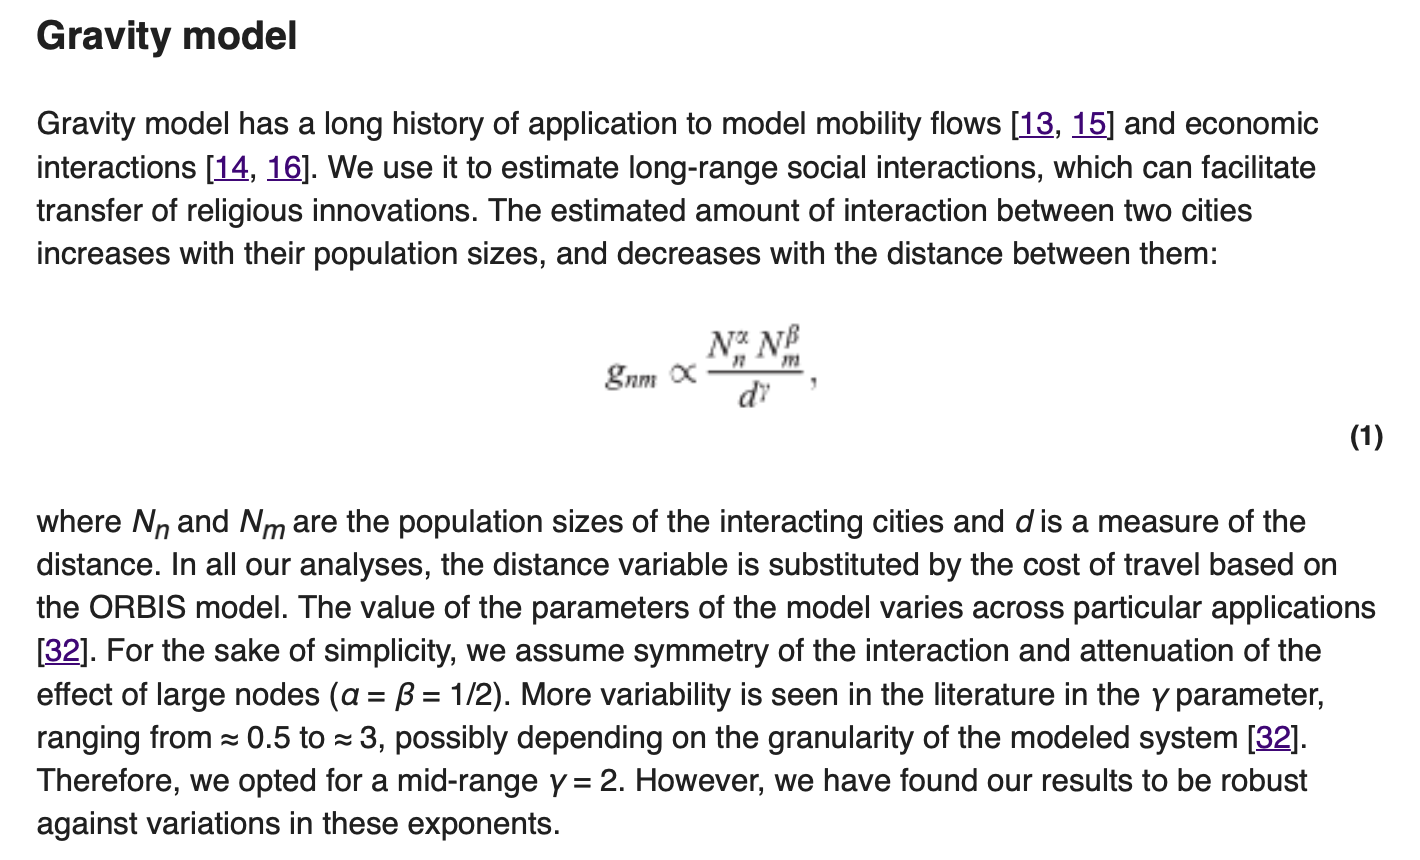

In [147]:
1000**0.5 * 1000**0.5

1000.0

In [148]:
def get_gravity(node1_pop, node2_pop, expense, gamma=2, alpha_beta = 0.5):
    gravity = (node1_pop**alpha_beta * node1_pop**alpha_beta) / (expense**gamma)
    return gravity

for keypair in edge_dict_undirected.keys():
    node1_pop = nodes_dict[keypair[0]]["pop_est"]
    node2_pop = nodes_dict[keypair[0]]["pop_est"]
    expense = edge_dict_undirected[keypair]["expense"]
    edge_dict_undirected[keypair]["gravity"] = get_gravity(node1_pop, node2_pop, expense)

In [149]:
for keypair in edge_dict_undirected.keys():
     edge_dict_undirected[keypair]["gravity_inverse"] = 1 / edge_dict_undirected[keypair]["gravity"]

In [150]:
edge_dict_undirected

{(50001, 50056): {'km': 54.539,
  'expense_inverse': 0.5238344683080146,
  'expense': 1.909,
  'days': 1.818,
  'route_type': 'road/road',
  'gravity': 274.4025501875404,
  'gravity_inverse': 0.0036442810000000005},
 (50001, 50100): {'km': 50.135,
  'expense_inverse': 0.5698005698005698,
  'expense': 1.755,
  'days': 1.671,
  'route_type': 'road/road',
  'gravity': 324.67268934505404,
  'gravity_inverse': 0.0030800249999999997},
 (50001, 50293): {'km': 65.681,
  'expense_inverse': 0.43497172683775553,
  'expense': 2.299,
  'days': 2.189,
  'route_type': 'road/road',
  'gravity': 189.20040314821904,
  'gravity_inverse': 0.0052854009999999995},
 (50001, 50473): {'km': 225.368,
  'expense_inverse': 0.12677484787018256,
  'expense': 7.888,
  'days': 7.512,
  'route_type': 'road/road',
  'gravity': 16.07186205250793,
  'gravity_inverse': 0.062220543999999996},
 (50002, 50275): {'km': 92.174,
  'expense_inverse': 0.30998140111593303,
  'expense': 3.226,
  'days': 3.072,
  'route_type': 'road

In [151]:
# create a network from the edges data
G = nx.convert_matrix.from_pandas_edgelist(orbis_edges_stanford, "source", "target")

# add edge attributes
nx.set_edge_attributes(G, edge_dict_undirected)

nx.set_node_attributes(G, nodes_dict)

In [152]:
nx.is_directed(G)

False

In [153]:
G.edges(data=True)

EdgeDataView([(50001, 50056, {'km': 54.539, 'expense_inverse': 0.5238344683080146, 'expense': 1.909, 'days': 1.818, 'route_type': 'road/road', 'gravity': 274.4025501875404, 'gravity_inverse': 0.0036442810000000005}), (50001, 50100, {'km': 50.135, 'expense_inverse': 0.5698005698005698, 'expense': 1.755, 'days': 1.671, 'route_type': 'road/road', 'gravity': 324.67268934505404, 'gravity_inverse': 0.0030800249999999997}), (50001, 50293, {'km': 65.681, 'expense_inverse': 0.43497172683775553, 'expense': 2.299, 'days': 2.189, 'route_type': 'road/road', 'gravity': 189.20040314821904, 'gravity_inverse': 0.0052854009999999995}), (50001, 50473, {'km': 225.368, 'expense_inverse': 0.12677484787018256, 'expense': 7.888, 'days': 7.512, 'route_type': 'road/road', 'gravity': 16.07186205250793, 'gravity_inverse': 0.062220543999999996}), (50056, 50314, {'km': 126.177, 'expense_inverse': 0.22644927536231882, 'expense': 4.416, 'days': 4.206, 'route_type': 'road/road', 'gravity': 543.9705419029615, 'gravity_

In [154]:
positions = dict(zip(orbis_hanson_gpd["id"].tolist(), list(np.column_stack((orbis_hanson_gpd["y"], orbis_hanson_gpd["x"])))))

In [155]:
### # pelagios provinces - to be used as a base map in our plots
url = "https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson"
pleiades_regions = gpd.read_file(url)
pleiades_regions.head(5)

,name,uri,geometry
0,Lusitania,http://pleiades.stoa.org/places/1101,"POLYGON ((-7.31057 37.19663, -7.32457 37.19556..."
1,Byzacena,http://pleiades.stoa.org/places/991345,"MULTIPOLYGON (((11.01815 34.62424, 11.00879 34..."
2,Viennensis,http://pleiades.stoa.org/places/992074,"POLYGON ((4.62344 45.60642, 4.71224 45.60876, ..."
3,Lycia et Pamphylia,http://pleiades.stoa.org/places/981530,"MULTIPOLYGON (((29.62331 36.07470, 29.61295 36..."
4,Savia,http://pleiades.stoa.org/places/991357,"POLYGON ((18.10598 45.77203, 18.10654 45.71079..."


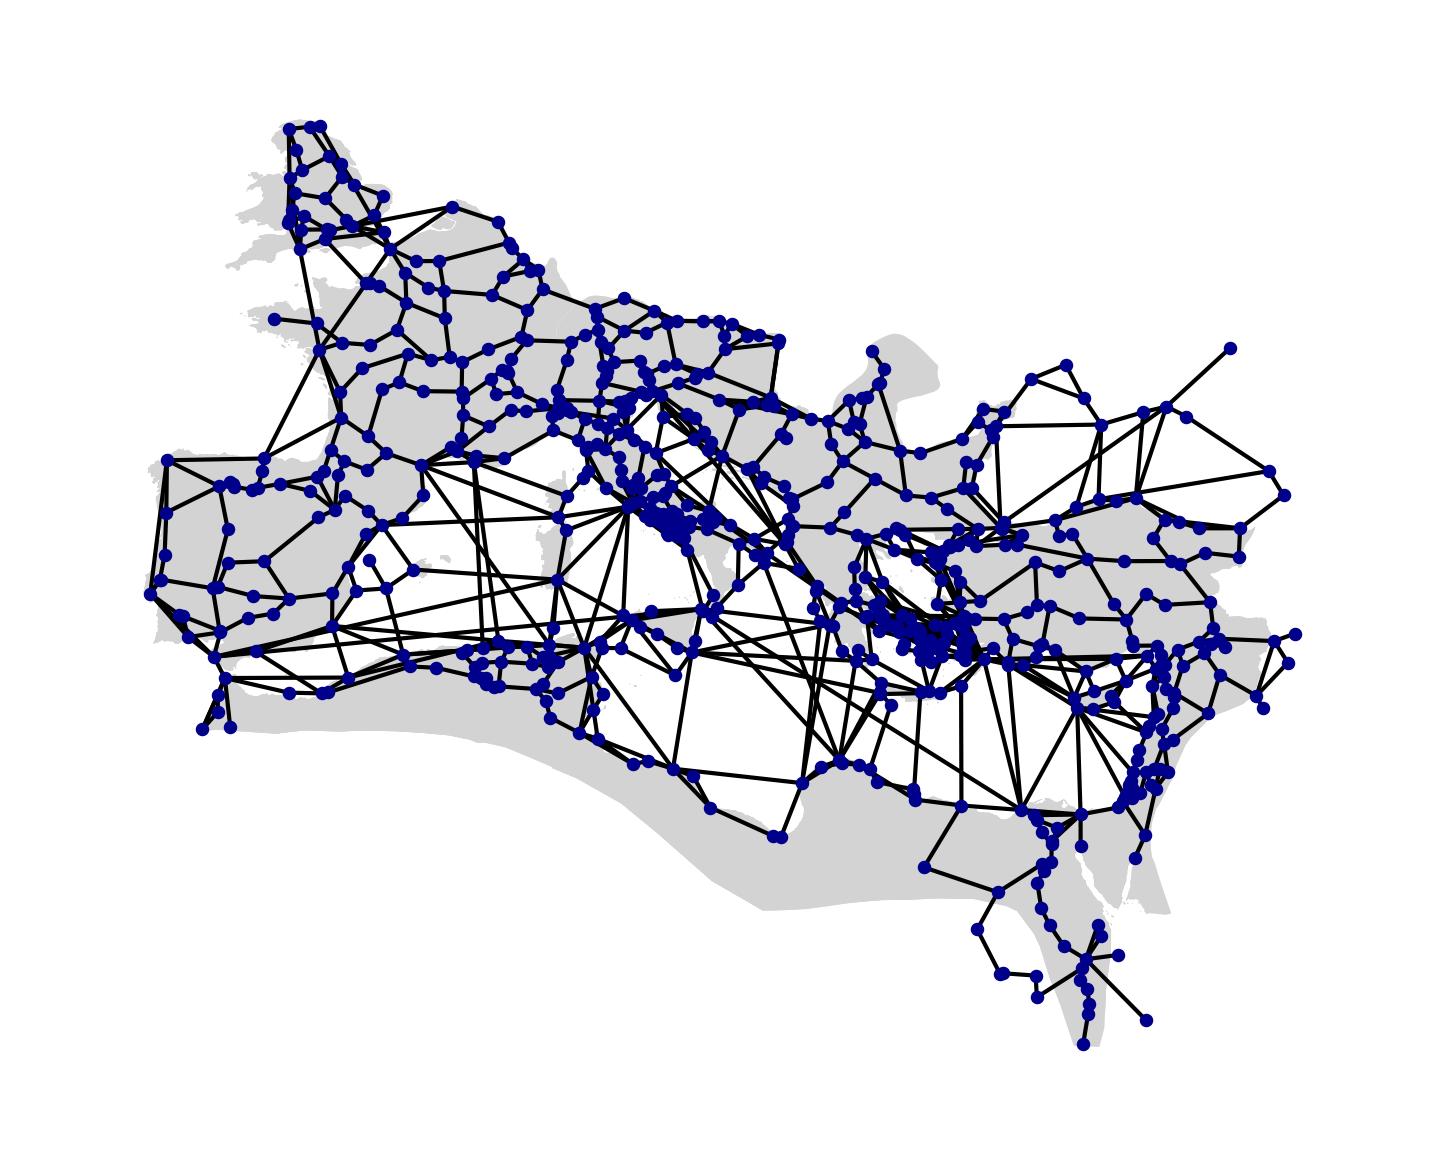

In [156]:
fig, ax = plt.subplots(figsize=[5.2, 4], tight_layout=True)
pleiades_regions.plot(color="lightgray", ax=ax)

nx.draw(G, positions, with_labels=False, node_size=5, node_color="darkblue", node_shape="o", linewidths=1, ax=ax)
ax.set_axis_off()

In [157]:
# export for future reuse (within python)
nx.write_gpickle(G, "../data/orbis_network_enriched.pickle")

In [158]:
nx.write_graphml(G, "../data/orbis_network_enriched.graphml")

In [159]:
G_graphml = nx.read_graphml("../data/orbis_network_enriched.graphml")
G_graphml.edges(data=True)

EdgeDataView([('50001', '50056', {'km': 54.539, 'expense_inverse': 0.5238344683080146, 'expense': 1.909, 'days': 1.818, 'route_type': 'road/road', 'gravity': 274.4025501875404, 'gravity_inverse': 0.0036442810000000005}), ('50001', '50100', {'km': 50.135, 'expense_inverse': 0.5698005698005698, 'expense': 1.755, 'days': 1.671, 'route_type': 'road/road', 'gravity': 324.67268934505404, 'gravity_inverse': 0.0030800249999999997}), ('50001', '50293', {'km': 65.681, 'expense_inverse': 0.43497172683775553, 'expense': 2.299, 'days': 2.189, 'route_type': 'road/road', 'gravity': 189.20040314821904, 'gravity_inverse': 0.0052854009999999995}), ('50001', '50473', {'km': 225.368, 'expense_inverse': 0.12677484787018256, 'expense': 7.888, 'days': 7.512, 'route_type': 'road/road', 'gravity': 16.07186205250793, 'gravity_inverse': 0.062220543999999996}), ('50056', '50314', {'km': 126.177, 'expense_inverse': 0.22644927536231882, 'expense': 4.416, 'days': 4.206, 'route_type': 'road/road', 'gravity': 543.9705